In [19]:
# Block 1: Imports
import os
os.environ.setdefault("DDE_BACKEND", "pytorch")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

import time
import random
import json
import math
from collections import OrderedDict

import numpy as np
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

import MAS_library as MASL
from torch.amp import GradScaler, autocast

In [20]:
# Block 2: Run/Paths/IO
RUN_NAME = "T2ROI-emph V2 Compare"
RESUME_FROM_CHECKPOINT = False
RESET_LOGS_ON_FRESH_START = True

BASE_DIR    = "./runs"
RUN_DIR     = os.path.join(BASE_DIR, RUN_NAME)
CKPT_DIR    = os.path.join(RUN_DIR, "checkpoints")
LOGS_DIR    = os.path.join(RUN_DIR, "logs")
DATA_DIR    = "./data"
PRECOMP_DIR = os.path.join(DATA_DIR, "precomputed")

checkpoint_path   = os.path.join(CKPT_DIR, f"{RUN_NAME}_checkpoint.pt")
best_model_path   = os.path.join(CKPT_DIR, f"{RUN_NAME}_best_model.pt")
metrics_log_path  = os.path.join(LOGS_DIR,  f"{RUN_NAME}_epoch_metrics.txt")
train_log_path    = os.path.join(LOGS_DIR,  f"{RUN_NAME}_train_log.txt")
diag_jsonl_path   = os.path.join(LOGS_DIR,  f"{RUN_NAME}_epoch_diag.jsonl")

for d in (BASE_DIR, RUN_DIR, CKPT_DIR, LOGS_DIR, DATA_DIR, PRECOMP_DIR):
    os.makedirs(d, exist_ok=True)

def _append_train_line(text: str):
    try:
        with open(train_log_path, "a", encoding="utf-8") as f:
            f.write(text.rstrip() + "\n")
    except Exception as e:
        print(f"[warn] couldn't write train log: {e}")

def _append_jsonl_line(text: str):
    try:
        with open(diag_jsonl_path, "a", encoding="utf-8") as f:
            f.write(text.rstrip() + "\n")
    except Exception as e:
        print(f"[warn] couldn't write diag jsonl: {e}")

print(f"[run] RUN_NAME={RUN_NAME}")
print(f"[run] RUN_DIR={RUN_DIR}")
print(f"[run] CKPT_DIR={CKPT_DIR}")
print(f"[run] LOGS_DIR={LOGS_DIR}")
print(f"[run] checkpoint_path={checkpoint_path}")
print(f"[run] best_model_path={best_model_path}")
print(f"[run] metrics_log_path={metrics_log_path}")
print(f"[run] train_log_path={train_log_path}")
print(f"[run] diag_jsonl_path={diag_jsonl_path}")

[run] RUN_NAME=T2ROI-emph V2 Compare
[run] RUN_DIR=./runs/T2ROI-emph V2 Compare
[run] CKPT_DIR=./runs/T2ROI-emph V2 Compare/checkpoints
[run] LOGS_DIR=./runs/T2ROI-emph V2 Compare/logs
[run] checkpoint_path=./runs/T2ROI-emph V2 Compare/checkpoints/T2ROI-emph V2 Compare_checkpoint.pt
[run] best_model_path=./runs/T2ROI-emph V2 Compare/checkpoints/T2ROI-emph V2 Compare_best_model.pt
[run] metrics_log_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_epoch_metrics.txt
[run] train_log_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_train_log.txt
[run] diag_jsonl_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_epoch_diag.jsonl


In [21]:
# Block 3: Device/Seeds/Knobs
print("torch:", torch.__version__)
print("cuda runtime in torch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU[0]:", torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')

BoxSize  = 100.0
grid     = 64
cellsize = BoxSize / grid
MAS      = 'CIC'
verbose  = False
threads  = 4

num_sim            = 1000
lambda_p           = 1.0
total_epochs       = 60
epochs_per_quarter = total_epochs // 4

eff_batch_size = 112
micro_batch    = 16
ACCUM_STEPS    = max(1, eff_batch_size // micro_batch)
batch_size     = micro_batch

lr       = 0.001
VAL_FRAC = 0.05

N_FOURIER       = 10
INCLUDE_RAW_POS = False

EPS_RHO   = 1e-3
EPS_DET   = 1e-3
NEG_DET_W = 1e-2

ENABLE_ROI        = False
ROI_CONDITIONING  = True
K_LOW_MAX         = 0.18
K_HIGH_MIN        = 0.22
K_TRANS           = 0.04
ROI_SIZES         = [40, 48, 56]
ROI_TAPER         = 10

# Displacement normalization
#   "box"  -> psi' = psi / BoxSize
#   "cell" -> psi' = psi / cellsize
#   None   -> no normalization
DISP_NORM = "box"

if DISP_NORM == "box":
    DISP_SCALE = 1.0 / BoxSize
elif DISP_NORM == "cell":
    DISP_SCALE = 1.0 / cellsize
else:
    DISP_NORM = None
    DISP_SCALE = 1.0

DISP_INV_SCALE = 1.0 / DISP_SCALE
print(f"[units] DISP_NORM={DISP_NORM}  DISP_SCALE={DISP_SCALE:g}  DISP_INV_SCALE={DISP_INV_SCALE:g}")

WARMUP_EPOCHS  = 5
MIN_LR_FACTOR  = 0.08
NOCLIP_EPOCHS  = 1
MAX_GRAD_NORM  = 5.0

PATIENCE = 5

DIAG_JSON_EVERY    = 1
DIAG_ON_FIRST_LAST = True
DIAG_ON_BEST       = True
DIAG_TO_STDOUT     = False
DIAG_TO_JSONL      = True

SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

generator = torch.Generator(device='cpu')
generator.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id: int):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ==== DeepONet toggle & knobs ====
USE_DEEPONET   = True
DO_NUM_SENSORS = 9261     # 21^3 lattice (good spatial coverage, still light)
DO_LATENT      = 256      # keep 256; going higher hits memory (t has p*C channels)
DO_TRUNK_W     = (256, 256)
DO_BRANCH_W    = (512, 512)




torch: 2.8.0+cu128
cuda runtime in torch: 12.8
CUDA available: True
GPU[0]: NVIDIA A100-SXM4-80GB
device: cuda
[units] DISP_NORM=box  DISP_SCALE=0.01  DISP_INV_SCALE=100


In [22]:
# Block 4: Precomputed Geometry
q_coords = torch.linspace(0, BoxSize - cellsize, grid, device=device)
q1, q2, q3 = torch.meshgrid(q_coords, q_coords, q_coords, indexing='ij')
Q = torch.stack((q1, q2, q3), dim=0)

x_norm = q1 / BoxSize # X coordinate of each point in Q-system 
y_norm = q2 / BoxSize # Y coordinate of each point in Q-system 
z_norm = q3 / BoxSize # Z coordinate of each point in Q-system 

freq_bands = torch.tensor([2.0**k for k in range(N_FOURIER)], device=device)
two_pi = 2.0 * np.pi

pos_feats = []
if INCLUDE_RAW_POS:
    pos_feats += [x_norm, y_norm, z_norm]
for f in freq_bands:
    ax = two_pi * f * x_norm
    ay = two_pi * f * y_norm
    az = two_pi * f * z_norm
    pos_feats += [torch.sin(ax), torch.cos(ax), torch.sin(ay), torch.cos(ay), torch.sin(az), torch.cos(az)]

pos_embed = torch.stack(pos_feats, dim=0).contiguous()
Cpos = pos_embed.shape[0]
print(f"Fourier features: Cpos={Cpos} channels")

k_base = 2 * np.pi * torch.fft.fftfreq(grid, d=cellsize).to(device)
k_z, k_y, k_x = torch.meshgrid(k_base, k_base, k_base, indexing='ij')

RAW_DATA_DIR = "/vast/palmer/pi/padmanabhan/shared/LSS"
data_dir = RAW_DATA_DIR
precomputed_dir = PRECOMP_DIR

Fourier features: Cpos=60 channels


In [23]:
# Block 5: Precompute
def run_precompute(num_sim: int, data_dir: str, precomputed_dir: str,
                   grid: int, BoxSize: float, MAS: str, verbose: bool):
    start_time = time.time()
    skipped, wrote = 0, 0
    for isim in tqdm(range(num_sim), desc="Precompute ρ/ρ̄ and ψ̃"):
        pre_file = os.path.join(precomputed_dir, f"LSS_{isim}_pre.h5")
        if os.path.exists(pre_file):
            skipped += 1; continue
        file_path = os.path.join(data_dir, f'LSS_{isim}_L100_G64.h5')
        with h5py.File(file_path, 'r') as f:
            position     = np.array(f['position'][:],     dtype=np.float32)
            displacement = np.array(f['displacement'][:], dtype=np.float32)
        rho = np.zeros((grid, grid, grid), dtype=np.float32)
        MASL.MA(position, rho, BoxSize, MAS, verbose=verbose)
        mean_rho   = np.mean(rho, dtype=np.float64)
        rho_rhobar = rho / mean_rho
        tilde_psi = -displacement.reshape(grid, grid, grid, 3).astype(np.float32)
        os.makedirs(precomputed_dir, exist_ok=True)
        with h5py.File(pre_file, 'w') as f:
            f.create_dataset('rho_rhobar', data=rho_rhobar)
            f.create_dataset('tilde_psi',  data=tilde_psi)
        wrote += 1
    elapsed = time.time() - start_time
    print(f"Preprocessing took {elapsed:.2f}s | wrote {wrote}, skipped {skipped}.")

In [24]:
# Block 6: Dataset/Loaders
class LSSDataset(Dataset):
    def __init__(self, precomputed_dir, num_sim, preload=False, cache_size=0, np_dtype=np.float16, scale_disp: float = 1.0):
        self.precomputed_dir = precomputed_dir
        self.num_sim = int(num_sim)
        self.np_dtype = np_dtype
        self.cache_size = int(cache_size)
        self.scale_disp = float(scale_disp)
        self.cache = OrderedDict()
        if preload:
            for idx in tqdm(range(self.num_sim)):
                self.cache[idx] = self._load_np(idx)
                if self.cache_size and len(self.cache) > self.cache_size:
                    self.cache.popitem(last=False)

    def __len__(self): return self.num_sim

    def _load_np(self, idx):
        pre_file = os.path.join(self.precomputed_dir, f"LSS_{idx}_pre.h5")
        with h5py.File(pre_file, "r") as f:
            rho = np.array(f["rho_rhobar"][:], dtype=self.np_dtype)
            tilde_psi = np.array(f["tilde_psi"][:], dtype=self.np_dtype)
        return rho, tilde_psi

    def _to_torch(self, rho_np, psi_np):
        rho = torch.from_numpy(rho_np).unsqueeze(0)  # (1, G, G, G)
        tilde_psi = torch.from_numpy(psi_np).permute(3, 0, 1, 2) * self.scale_disp  # (3, G, G, G)
        return rho, tilde_psi

    def __getitem__(self, idx):
        if idx in self.cache:
            rho_np, psi_np = self.cache.pop(idx); self.cache[idx] = (rho_np, psi_np)
            return self._to_torch(rho_np, psi_np)
        rho_np, psi_np = self._load_np(idx)
        if self.cache_size:
            self.cache[idx] = (rho_np, psi_np)
            if len(self.cache) > self.cache_size:
                self.cache.popitem(last=False)
        return self._to_torch(rho_np, psi_np)

def make_loaders(precomputed_dir, num_sim, batch_size, VAL_FRAC, device, generator):
    dataset = LSSDataset(precomputed_dir, num_sim, preload=False, cache_size=512, np_dtype=np.float32,
                         scale_disp=DISP_SCALE)
    n_total = len(dataset)
    n_val = max(1, int(round(n_total * VAL_FRAC)))
    perm = torch.randperm(n_total, generator=generator).tolist()
    val_idx = perm[:n_val]; train_idx = perm[n_val:]
    train_ds = Subset(dataset, train_idx); val_ds = Subset(dataset, val_idx)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=threads,
        pin_memory=(device.type == 'cuda'), persistent_workers=True,
        worker_init_fn=seed_worker, generator=generator,
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, num_workers=threads,
        pin_memory=(device.type == 'cuda'), persistent_workers=True,
        worker_init_fn=seed_worker, generator=generator,
    )
    return dataset, train_loader, val_loader

In [34]:
# Block 7:DeepONet
import math
import torch
import torch.nn as nn

class DeepONet3D(nn.Module):
    """
    y_c(x) = alpha[c] * <B([g_norm, amp]), T_c(x)> + b[c]
      - g_norm : z-scored lattice sensors from rho (per-sample)
      - amp    : per-sample amplitude token = std(rho)  👈 NEW
    """
    def __init__(self,
                 pos_embed: torch.Tensor,           # [Cpos, G, G, G]
                 num_sensors: int = 4096,
                 latent_dim: int = 256,
                 branch_widths=(512, 512),
                 trunk_widths=(256, 256),
                 out_channels: int = 3,
                 include_cond: bool = False,
                 seed: int = 42):
        super().__init__()
        assert pos_embed.ndim == 4, f"pos_embed must be [Cpos,G,G,G], got {pos_embed.shape}"
        self.register_buffer('pos_embed', pos_embed.float(), persistent=False)
        Cpos, G, _, _ = pos_embed.shape
        self.grid = int(G)
        self.out_channels = int(out_channels)
        self.latent_dim   = int(latent_dim)
        N_pts = G * G * G

        # ---- lattice sensors ----
        M_req = max(8, min(int(num_sensors), N_pts))
        m = max(2, round(M_req ** (1/3)))
        xs = torch.linspace(0, G-1, m).round().long()
        ijk = torch.stack(torch.meshgrid(xs, xs, xs, indexing='ij'), dim=-1).reshape(-1, 3)
        sensor_idx = (ijk[:,0] * G + ijk[:,1]) * G + ijk[:,2]
        self.register_buffer('sensor_idx', sensor_idx, persistent=False)
        self.num_sensors = int(sensor_idx.numel())

        # ---- Branch: LayerNorm(g_norm) + amp token -> MLP -> R^p ----
        self.branch_norm = nn.LayerNorm(self.num_sensors)         # LN for sensors only
        branch_in = self.num_sensors + 1                           # 👈 +1 for amp token
        b_layers, prev = [], branch_in
        for w in list(branch_widths):
            b_layers += [nn.Linear(prev, w), nn.SiLU()]
            prev = w
        b_layers += [nn.Linear(prev, latent_dim)]
        self.branch = nn.Sequential(*b_layers)

        # ---- Trunk: 1×1 Conv3d chain on pos_embed -> R^{p*C} ----
        Cin = Cpos
        t_layers, prev_c = [], Cin
        for w in list(trunk_widths):
            t_layers += [nn.Conv3d(prev_c, w, kernel_size=1), nn.SiLU(inplace=True)]
            prev_c = w
        t_layers += [nn.Conv3d(prev_c, latent_dim * out_channels, kernel_size=1)]
        self.trunk = nn.Sequential(*t_layers)

        # Per-channel gain & bias
        self.alpha = nn.Parameter(torch.ones(out_channels))
        self.bias  = nn.Parameter(torch.zeros(out_channels))
        self._init_weights()

    def _init_weights(self):
        for m in self.branch.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
                    nn.init.uniform_(m.bias, -bound, bound)
        for m in self.trunk.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, rho: torch.Tensor, cond: torch.Tensor | None = None) -> torch.Tensor:
        """
        rho:  [B, 1, G, G, G]
        return: [B, 3, G, G, G]
        """
        B, _, G, _, _ = rho.shape

        # # --- per-sample stats from RAW rho (keep amp!) ---
        mu_raw  = rho.mean(dim=(2,3,4), keepdim=True)
        std_raw = rho.std(dim=(2,3,4), keepdim=True).clamp_min(1e-6)
        amp     = std_raw.view(B, 1)                            

        # --- normalized sensors for stability ---
        rho_flat = rho.view(B, -1)
        g = torch.index_select(rho_flat, 1, self.sensor_idx)       # [B, M]
        g = self.branch_norm(g)                         
        g_full = torch.cat([g, amp.to(g.dtype)], dim=1) 
        b_code = self.branch(g_full)

        # --- trunk on pos_embed (shared across batch) ---
        trunk_in = self.pos_embed.unsqueeze(0).to(dtype=rho.dtype, device=rho.device)
        t = self.trunk(trunk_in)                                   # [1, p*C, G, G, G]
        t = t.view(1, self.out_channels, self.latent_dim, G, G, G).expand(B, -1, -1, -1, -1, -1)

        # --- inner product + per-channel gain ---
        # b_code: [B, p]
        # t:      [B, C, p, G, G, G]
        weights = b_code[:, None, :, None, None, None]   # [B, 1, p, 1, 1, 1]
        y = (t * weights).sum(dim=2)                     # sum over p -> [B, C, G, G, G]
        y = y * self.alpha.view(1, -1, 1, 1, 1) + self.bias.view(1, -1, 1, 1, 1)
        return y


In [35]:
# Block 8: Core Math
def get_derivative(field, axis):
    fft = torch.fft.fftn(field, dim=(2, 3, 4))
    if axis == 0: k = k_z
    elif axis == 1: k = k_y
    else: k = k_x
    k = k.unsqueeze(0).unsqueeze(0).expand_as(fft)
    deriv_ft = 1j * k * fft
    deriv = torch.fft.ifftn(deriv_ft, dim=(2, 3, 4)).real
    return deriv

def periodic_interpolate3d(rho, coords):
    B = rho.shape[0]
    G = grid
    rho_flat = rho.reshape(B, 1, -1)
    coords = (coords % BoxSize) / cellsize
    coords_flat = coords.reshape(B, -1, 3)
    i_flat = torch.floor(coords_flat).long()
    f_flat = coords_flat - i_flat.float()
    i0 = (i_flat % G)
    i1 = ((i_flat + 1) % G)
    def get_value(iz, iy, ix):
        idx = ((iz * G + iy) * G + ix).unsqueeze(1)
        v = torch.gather(rho_flat, 2, idx).squeeze(1)
        return v
    v000 = get_value(i0[:,:,0], i0[:,:,1], i0[:,:,2])
    v001 = get_value(i0[:,:,0], i0[:,:,1], i1[:,:,2])
    v010 = get_value(i0[:,:,0], i1[:,:,1], i0[:,:,2])
    v011 = get_value(i0[:,:,0], i1[:,:,1], i1[:,:,2])
    v100 = get_value(i1[:,:,0], i0[:,:,1], i0[:,:,2])
    v101 = get_value(i1[:,:,0], i0[:,:,1], i1[:,:,2])
    v110 = get_value(i1[:,:,0], i1[:,:,1], i0[:,:,2])
    v111 = get_value(i1[:,:,0], i1[:,:,1], i1[:,:,2])
    fx = f_flat[:,:,2]; fy = f_flat[:,:,1]; fz = f_flat[:,:,0]
    wa = (1 - fx) * (1 - fy) * (1 - fz)
    wb = fx * (1 - fy) * (1 - fz)
    wc = (1 - fx) * fy * (1 - fz)
    wd = fx * fy * (1 - fz)
    we = (1 - fx) * (1 - fy) * fz
    wf = fx * (1 - fy) * fz
    wg = (1 - fx) * fy * fz
    wh = fx * fy * fz
    interpolated_flat = (wa * v000 + wb * v001 + wc * v010 + wd * v011 +
                         we * v100 + wf * v101 + wg * v110 + wh * v111)
    interpolated = interpolated_flat.reshape(B, grid, grid, grid)
    return interpolated

In [36]:
# Block 9: Spatial Losses
def _sobel_kernels_3d(dtype, device):
    s = torch.tensor([1.0, 2.0, 1.0], dtype=dtype, device=device)
    d = torch.tensor([1.0, 0.0, -1.0], dtype=dtype, device=device)
    Gx = torch.einsum('z,y,x->zyx', s, s, d) / 32.0
    Gy = torch.einsum('z,y,x->zyx', s, d, s) / 32.0
    Gz = torch.einsum('z,y,x->zyx', d, s, s) / 32.0
    K = torch.stack([Gx, Gy, Gz], dim=0).unsqueeze(1)
    return K

def grad_loss_3d(pred, target):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _sobel_kernels_3d(dtype=pred.dtype, device=pred.device)
    loss = 0.0
    for axis in range(3):
        w_axis = K[axis:axis+1].repeat(C, 1, 1, 1, 1)
        gp = F.conv3d(pred,   w_axis, padding=1, groups=C)
        gt = F.conv3d(target, w_axis, padding=1, groups=C)
        loss = loss + F.l1_loss(gp, gt)
    return loss / 3.0

def displacement_loss_3d(pred, target, w_data=1.0, w_grad=0.3):
    return w_data * F.l1_loss(pred, target) + w_grad * grad_loss_3d(pred, target)

def _laplacian_kernel_3d(dtype, device):
    K = torch.zeros((1,1,3,3,3), dtype=dtype, device=device)
    K[0,0,1,1,1] = -6.0
    K[0,0,1,1,0] =  1.0
    K[0,0,1,1,2] =  1.0
    K[0,0,1,0,1] =  1.0
    K[0,0,1,2,1] =  1.0
    K[0,0,0,1,1] =  1.0
    K[0,0,2,1,1] =  1.0
    return K

def laplacian_loss(pred, target):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _laplacian_kernel_3d(dtype=pred.dtype, device=pred.device)
    Kc = K.repeat(C, 1, 1, 1, 1)
    Lp = F.conv3d(pred,   Kc, padding=1, groups=C)
    Lt = F.conv3d(target, Kc, padding=1, groups=C)
    return F.l1_loss(Lp, Lt)

def edge_aware_l1(pred, target, beta=2.0, eps=1e-12):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _sobel_kernels_3d(dtype=target.dtype, device=target.device)
    Kc = K.repeat(C, 1, 1, 1, 1)
    gx = F.conv3d(target, Kc[0::3], padding=1, groups=C)
    gy = F.conv3d(target, Kc[1::3], padding=1, groups=C)
    gz = F.conv3d(target, Kc[2::3], padding=1, groups=C)
    grad_mag = torch.sqrt(gx**2 + gy**2 + gz**2)
    w = 1.0 + beta * grad_mag
    num = (w * torch.abs(pred - target)).sum()
    den = w.sum().clamp_min(eps)
    return num / den

In [37]:
# Block 10: Spectral Losses
k_mag = torch.sqrt(k_x**2 + k_y**2 + k_z**2)
k_max = k_mag.max().clamp_min(1e-8)
k_weight = (k_mag / k_max).to(dtype=torch.float32)

def _soft_step(x, center, width):
    t = (x - center) / max(width, 1e-8)
    t = torch.clamp(t, -1.0, 1.0)
    return 0.5 * (1.0 + torch.sin(0.5 * np.pi * t))

def _highpass_mask(kmin, trans):
    return _soft_step(k_mag, kmin, trans)

def _lowpass_mask(kmax_, trans):
    return 1.0 - _soft_step(k_mag, kmax_, trans)

def make_partition_masks(k_low_max, k_high_min, trans=0.04):
    m_low  = _lowpass_mask(kmax_=k_low_max,  trans=trans)
    m_high = _highpass_mask(kmin=k_high_min, trans=trans)
    den = (m_low + m_high).clamp_min(1e-6)
    return (m_low / den, m_high / den)

def spectral_loss_band(pred, target, mask, p=1.0, relative=True, eps=1e-10, floor_frac=0.05):
    B, C, D, H, W = pred.shape
    norm = (D * H * W)
    Fp = torch.fft.fftn(pred.float(),   dim=(2, 3, 4)) / norm
    Ft = torch.fft.fftn(target.float(), dim=(2, 3, 4)) / norm
    wk = (k_mag / k_max).pow(p).to(dtype=torch.float32)
    w  = (mask * wk).unsqueeze(0).unsqueeze(0)
    diff2 = (Fp - Ft).abs().pow(2)
    if relative:
        num   = (diff2 * w).mean()
        base  = (Ft.abs().pow(2) * w).mean()
        base_unw = (Ft.abs().pow(2) * mask.unsqueeze(0).unsqueeze(0)).mean()
        denom = torch.maximum(base, floor_frac * base_unw).clamp_min(eps)
        return num / denom
    else:
        return (diff2 * w).mean()

def spectral_lowfreq_loss(pred, target, kmax_, trans=0.03, p=0.25, **kw):
    mask = _lowpass_mask(kmax_=kmax_, trans=trans)
    return spectral_loss_band(pred, target, mask=mask, p=p, **kw)

def spectral_highfreq_loss_band(pred, target, kmin, trans=0.03, p=1.0, **kw):
    mask = _highpass_mask(kmin=kmin, trans=trans)
    return spectral_loss_band(pred, target, mask=mask, p=p, **kw)

def spectral_highfreq_loss(pred, target, p=1.0, relative=True, exclude_dc=True, eps=1e-12):
    B, C, D, H, W = pred.shape
    norm = (D * H * W)
    Fp = torch.fft.fftn(pred.float(),   dim=(2, 3, 4)) / norm
    Ft = torch.fft.fftn(target.float(), dim=(2, 3, 4)) / norm
    w_base = (k_mag / k_max).pow(p).to(dtype=torch.float32)
    if exclude_dc:
        w_base = w_base.clone()
        w_base[0, 0, 0] = 0.0
    w = w_base.unsqueeze(0).unsqueeze(0)
    diff = Fp - Ft
    num = (diff.abs().pow(2) * w).mean()
    if relative:
        denom = ((Ft.abs().pow(2) * w).mean()).clamp_min(eps)
        return num / denom
    else:
        return num

In [38]:
# Block 13: Schedules
def cos_ramp(frac, start, end, y0, y1):
    if end <= start:
        return y1
    t = (frac - start) / (end - start)
    t = max(0.0, min(1.0, t))
    return y0 + (y1 - y0) * 0.5 * (1.0 - np.cos(np.pi * t))

def schedule_weights(epoch_idx: int, total_epochs: int):
    f = (epoch_idx + 1) / float(total_epochs)
    Wspec_low  = cos_ramp(f, 0.00, 0.67, y0=0.20, y1=0.05)
    Wspec_high = cos_ramp(f, 0.50, 1.00, y0=0.06, y1=0.45)
    p_high     = cos_ramp(f, 0.50, 1.00, y0=1.20, y1=3.00)
    Wgrad      = cos_ramp(f, 0.50, 1.00, y0=0.60, y1=0.85)
    Wlap       = cos_ramp(f, 0.50, 1.00, y0=0.20, y1=0.28)
    Wedge      = cos_ramp(f, 0.60, 1.00, y0=0.20, y1=0.25)
    focus_prob = cos_ramp(f, 0.40, 1.00, y0=0.10, y1=0.55)
    Wphys      = cos_ramp(f, 0.00, 0.33, y0=0.30, y1=1.00)
    return Wspec_low, Wspec_high, p_high, Wgrad, Wlap, Wedge, focus_prob, Wphys

In [39]:
# Block 14: Model/Opt/Sched/State
import math

# ==== Choose model ====
if USE_DEEPONET:
    model = DeepONet3D(
        pos_embed=pos_embed,
        num_sensors=DO_NUM_SENSORS,
        latent_dim=DO_LATENT,
        branch_widths=DO_BRANCH_W,
        trunk_widths=DO_TRUNK_W,
        out_channels=3,
        include_cond=False,   # keep False for now (ignore cond); set True when we wire it
        seed=SEED
    ).to(device)
    print(f"[DeepONet] sensors={model.num_sensors}  latent={model.latent_dim}  grid={model.grid}")
else:
    model = UNet3D(pos_embed=pos_embed, use_cond=ROI_CONDITIONING).to(device)


optimizer = optim.Adam(model.parameters(), lr=lr)

def _lr_lambda(e):
    e1 = e + 1
    if e1 <= WARMUP_EPOCHS:
        return e1 / max(1, WARMUP_EPOCHS)
    t = (e1 - WARMUP_EPOCHS) / max(1, total_epochs - WARMUP_EPOCHS)
    floor = MIN_LR_FACTOR
    return floor + 0.5 * (1.0 - floor) * (1.0 + math.cos(math.pi * t))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=_lr_lambda)

USE_BF16 = (device.type == 'cuda') and torch.cuda.is_bf16_supported()
from torch import bfloat16 as _bf16, float16 as _fp16
AMP_DTYPE = _bf16 if USE_BF16 else _fp16
scaler = GradScaler('cuda', enabled=(device.type == 'cuda' and not USE_BF16))

data_losses, phys_losses, total_losses = [], [], []
val_data_losses, val_phys_losses, val_total_losses = [], [], []
base_disp_hist, lap_losses_hist, edge_losses_hist = [], [], []
spec_low_hist, spec_high_hist = [], []

best_loss = float('inf')
no_improve = 0
start_epoch = 0
last_epoch = 0

os.makedirs(os.path.dirname(metrics_log_path), exist_ok=True)
os.makedirs(os.path.dirname(train_log_path), exist_ok=True)
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

is_resuming = False
if RESUME_FROM_CHECKPOINT and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
    except RuntimeError as e:
        print(f"[warn] strict load failed ({e}); retrying strict=False")
        _incompat = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print(f"[info] missing={len(_incompat.missing_keys)} unexpected={len(_incompat.unexpected_keys)}")
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        except Exception as e:
            print(f"[warn] couldn't load scheduler state: {e}")
    data_losses        = checkpoint.get('data_losses', data_losses)
    phys_losses        = checkpoint.get('phys_losses', phys_losses)
    total_losses       = checkpoint.get('total_losses', total_losses)
    val_data_losses    = checkpoint.get('val_data_losses', val_data_losses)
    val_phys_losses    = checkpoint.get('val_phys_losses', val_phys_losses)
    val_total_losses   = checkpoint.get('val_total_losses', val_total_losses)
    best_loss          = checkpoint.get('best_loss', best_loss)
    no_improve         = checkpoint.get('no_improve', no_improve)
    start_epoch        = checkpoint.get('epoch', 0)
    base_disp_hist     = checkpoint.get('base_disp_hist', base_disp_hist)
    lap_losses_hist    = checkpoint.get('lap_losses_hist',  lap_losses_hist)
    edge_losses_hist   = checkpoint.get('edge_losses_hist', edge_losses_hist)
    spec_low_hist      = checkpoint.get('spec_low_hist',    spec_low_hist)
    spec_high_hist     = checkpoint.get('spec_high_hist',   spec_high_hist)
    is_resuming = True
    print(f"Resumed from epoch {start_epoch}")
else:
    print("Starting fresh training.")
    if RESET_LOGS_ON_FRESH_START:
        for p in (metrics_log_path, train_log_path, diag_jsonl_path):
            with open(p, "w", encoding="utf-8") as f:
                f.write(f"# New run: {RUN_NAME} @ {time.strftime('%Y-%m-%d %H:%M:%S')}\n")

[DeepONet] sensors=9261  latent=256  grid=64
Starting fresh training.


In [40]:
# Block 15: Diag Helpers
def _power_spectrum_auto_np(field, boxsize=100.0, nbins=60, subtract_mean=True):
    N = field.shape[0]
    a = field.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64)
    Fa = np.fft.fftn(a)
    V  = float(boxsize) ** 3
    P  = (Fa * np.conj(Fa)).real / V
    freqs = np.fft.fftfreq(N) * N
    kz, ky, kx = np.meshgrid(freqs, freqs, freqs, indexing="ij")
    kk = np.sqrt((2*np.pi*kx/boxsize)**2 + (2*np.pi*ky/boxsize)**2 + (2*np.pi*kz/boxsize)**2)
    k_flat, P_flat = kk.reshape(-1), P.reshape(-1)
    bins = np.linspace(0.0, float(k_flat.max()), nbins + 1)
    which = np.digitize(k_flat, bins) - 1
    P_sum = np.bincount(which, weights=P_flat, minlength=len(bins))
    k_sum = np.bincount(which, weights=k_flat, minlength=len(bins))
    cnt   = np.bincount(which, minlength=len(bins))
    mask  = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]
    Pk    = P_sum[mask] / cnt[mask]
    return k_bin, Pk

def _pk_snapshot_averaged(real_np, pred_np, boxsize, nbins=60,
                          k_min=0.1, k_max=3.0, k_step=0.1):
    P_true_list, P_pred_list = [], []
    k_ref = None
    for c in range(3):
        k_t, Pt = _power_spectrum_auto_np(real_np[c], boxsize=boxsize, nbins=nbins, subtract_mean=True)
        _,   Pp = _power_spectrum_auto_np(pred_np[c],  boxsize=boxsize, nbins=nbins, subtract_mean=True)
        if k_ref is None:
            k_ref = k_t
        P_true_list.append(Pt)
        P_pred_list.append(Pp)
    P_true_avg = np.mean(P_true_list, axis=0)
    P_pred_avg = np.mean(P_pred_list, axis=0)
    k_max_eff = float(k_ref.max()) if k_max is None else min(k_max, float(k_ref.max()))
    k_targets = np.arange(k_min, k_max_eff + 0.5 * k_step, k_step)
    out = []
    for kt in k_targets:
        bi = int(np.argmin(np.abs(k_ref - kt)))
        out.append((float(k_ref[bi]), float(P_true_avg[bi]), float(P_pred_avg[bi])))
    return out

def log_quick_diagnostics(model, dataset, device, boxsize=100.0, slice_idx=32):
    model.eval()
    rho, tilde_real = dataset[0]
    rho = rho.unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        pred = model(rho, cond=None)[0].detach().cpu().numpy()
    real = tilde_real.cpu().numpy()
    c = 0
    real_slice = real[c, :, :, slice_idx]
    pred_slice = pred[c, :, :, slice_idx]
    diff_slice = real_slice - pred_slice
    slice_stats = {
        "real_min": float(real_slice.min()),
        "real_max": float(real_slice.max()),
        "pred_min": float(pred_slice.min()),
        "pred_max": float(pred_slice.max()),
        "diff_min": float(diff_slice.min()),
        "diff_max": float(diff_slice.max()),
    }
    pk_rows = _pk_snapshot_averaged(real, pred, boxsize=boxsize, nbins=60, k_min=0.1, k_max=3.0, k_step=0.1)
    return slice_stats, pk_rows

In [41]:
# Block 16: Diag JSON Emit
def build_epoch_diag(model, dataset, device, boxsize=100.0, grid_size=64, slice_idx=None):
    if slice_idx is None:
        slice_idx = grid_size // 2
    slice_stats, pk_rows = log_quick_diagnostics(model, dataset, device, boxsize=boxsize, slice_idx=slice_idx)
    diag = {
        "slice_idx": int(slice_idx),
        "slice_stats": slice_stats,
        "pk_rows": [{"k": round(k, 3), "P_true": pt, "P_pred": pp} for (k, pt, pp) in pk_rows],
    }
    return diag

def emit_epoch_diag_json(model, dataset, device, boxsize=100.0, grid_size=64, slice_idx=None, prefix="[DIAG_JSON]"):
    diag = build_epoch_diag(model, dataset, device, boxsize=boxsize, grid_size=grid_size, slice_idx=slice_idx)
    return prefix + json.dumps(diag, separators=(",", ":"))

In [42]:
# Block 17: Train/Eval Loop
@torch.no_grad()
def evaluate_epoch(model, loader, mask_low, mask_high,
                   Wgrad, Wlap, Wedge, Wspec_low, Wspec_high, Wphys, p_high):
    model.eval()
    s_base = s_lap = s_edge = s_slow = s_shigh = s_data = s_phys = s_neg = 0.0
    n = 0
    for rho, tilde_psi in loader:
        rho = rho.to(device, dtype=torch.float32, non_blocking=True)
        tilde_psi = tilde_psi.to(device, dtype=torch.float32, non_blocking=True)
        pred = model(rho, cond=None)

        base  = displacement_loss_3d(pred, tilde_psi, w_data=1.0, w_grad=Wgrad)
        lap   = laplacian_loss(pred, tilde_psi)
        edge  = edge_aware_l1(pred, tilde_psi, beta=2.0)
        slow  = spectral_loss_band(pred, tilde_psi, mask=mask_low,  p=0.25,   relative=True)
        shigh = spectral_loss_band(pred, tilde_psi, mask=mask_high, p=p_high, relative=True)

        # phys, neg = compute_physics_loss(rho, pred, disp_inv_scale=DISP_INV_SCALE, return_aux=True)
        # phys = phys * (DISP_SCALE**2)
        
        phys = torch.tensor(0.0, device=pred.device)
        neg  = torch.tensor(0.0, device=pred.device)

        dc = (pred.mean(dim=(2,3,4))**2).mean()
        
        data = base + Wlap*lap + Wedge*edge + Wspec_low*slow + Wspec_high*shigh + 0.2*dc

        s_base += float(base.detach().cpu());   s_lap  += float(lap.detach().cpu())
        s_edge += float(edge.detach().cpu());   s_slow += float(slow.detach().cpu())
        s_shigh+= float(shigh.detach().cpu());  s_data += float(data.detach().cpu())
        # s_phys += float(phys.detach().cpu());   s_neg  += float(neg.detach().cpu())
        
        s_phys += 0.0;  s_neg += 0.0
        
        n += 1
    if n == 0:
        return (0.0,)*9
    avg_base = s_base/n; avg_lap = s_lap/n; avg_edge = s_edge/n
    avg_slow = s_slow/n; avg_shigh = s_shigh/n
    avg_data = s_data/n; avg_phys = s_phys/n; avg_neg = s_neg/n
    # avg_total = avg_data + (lambda_p * Wphys) * avg_phys
    
    avg_total = avg_data  # 不再加物理项
    
    return avg_base, avg_lap, avg_edge, avg_slow, avg_shigh, avg_data, avg_phys, avg_total, avg_neg

start_time = time.time()
first_pre = os.path.join(precomputed_dir, "LSS_0_pre.h5")
if not os.path.exists(first_pre):
    run_precompute(num_sim, data_dir, precomputed_dir, grid, BoxSize, MAS, verbose)

dataset, train_loader, val_loader = make_loaders(precomputed_dir, num_sim, batch_size, VAL_FRAC, device, generator)

# Inspect code magnitudes on one batch
model.eval()
rho_b, psi_b = next(iter(train_loader))
rho_b = rho_b.to(device, dtype=torch.float32)
with torch.no_grad():
    pred = model(rho_b)

# compute stats in the same cell
B = rho_b.shape[0]
mu  = rho_b.mean(dim=(2,3,4), keepdim=True)
std = rho_b.std(dim=(2,3,4), keepdim=True).clamp_min(1e-6)
amp = std.view(B,1)
print(f"amp mean={amp.mean().item():.4g}, pred std={pred.std().item():.4g}, true std={psi_b.to(pred.dtype).std().item():.4g}")



amp mean=4.468, pred std=0.05694, true std=0.04649


In [43]:
for epoch in range(start_epoch, total_epochs):
    epoch_start = time.time()

    total_base = total_lap = total_edge = 0.0
    total_spec_low = total_spec_high = 0.0
    total_data = total_phys = 0.0
    neg_det_accum = 0.0
    grad_norm_accum = 0.0
    grad_norm_count = 0
    n_batches = 0

    (W_SPEC_LOW_E, W_SPEC_HIGH_E, P_HIGH_E,
     W_GRAD_E,     W_LAPLACE_E,   W_EDGE_E,
     FOCUS_PROB_E, W_PHYS_E) = schedule_weights(epoch, total_epochs)

    mask_low_e, mask_high_e = make_partition_masks(K_LOW_MAX, K_HIGH_MIN, K_TRANS)

    model.train()
    optimizer.zero_grad(set_to_none=True)
    step_in_accum = 0

    for step, (rho, tilde_psi) in enumerate(tqdm(train_loader)):
        rho = rho.to(device, dtype=torch.float32, non_blocking=True)
        tilde_psi = tilde_psi.to(device, dtype=torch.float32, non_blocking=True)

        use_focus = (ENABLE_ROI and (random.random() < FOCUS_PROB_E))
        if use_focus:
            with torch.no_grad():
                K = _sobel_kernels_3d(dtype=rho.dtype, device=rho.device)
                gm = 0
                for axis in range(3):
                    w_axis = K[axis:axis+1]
                    gm = gm + F.conv3d(rho, w_axis, padding=1).abs()
                gm = gm.mean(dim=(0,1), keepdim=False)
                probs = (gm + 1e-8).reshape(-1)
                idx = torch.multinomial(probs, 1).item()
                cz_i = idx // (grid * grid)
                rem  = idx %  (grid * grid)
                cy_i = rem // grid
                cx_i = rem %  grid
                center = (torch.tensor(float(cz_i), device=rho.device, dtype=rho.dtype),
                          torch.tensor(float(cy_i), device=rho.device, dtype=rho.dtype),
                          torch.tensor(float(cx_i), device=rho.device, dtype=rho.dtype))
            size = random.choice(ROI_SIZES)
            M = make_roi_mask(grid, center=center, size=size, taper=ROI_TAPER,
                              device=rho.device, dtype=rho.dtype)
            cond = build_roi_condition(center, size, ROI_TAPER, device=rho.device, dtype=rho.dtype) if ROI_CONDITIONING else None
        else:
            M = None
            cond = None

        with autocast('cuda', dtype=AMP_DTYPE, enabled=(device.type == 'cuda')):
            pred = model(rho, cond=cond)
            if M is None:
                base_disp_loss = displacement_loss_3d(pred, tilde_psi, w_data=1.0, w_grad=W_GRAD_E)
                lap_loss       = laplacian_loss(pred, tilde_psi)
                edge_loss      = edge_aware_l1(pred, tilde_psi, beta=2.0)
            else:
                base_disp_loss = displacement_loss_3d_masked(pred, tilde_psi, M, w_data=1.0, w_grad=W_GRAD_E)
                lap_loss       = laplacian_loss_masked(pred, tilde_psi, M)
                edge_loss      = edge_aware_l1_masked(pred, tilde_psi, M, beta=2.0)

            spec_low_loss  = spectral_loss_band(pred, tilde_psi, mask=mask_low_e,  p=0.25,     relative=True)
            spec_high_loss = spectral_loss_band(pred, tilde_psi, mask=mask_high_e, p=P_HIGH_E, relative=True)

            # physics_loss, neg_det_frac = compute_physics_loss(
            #     rho, pred, disp_inv_scale=DISP_INV_SCALE, return_aux=True
            # )
            # physics_loss = physics_loss * (DISP_SCALE**2)
            # [PHYS OFF]
            physics_loss  = torch.tensor(0.0, device=pred.device, dtype=pred.dtype)
            neg_det_frac  = torch.tensor(0.0, device=pred.device, dtype=pred.dtype)

            dc_loss = (pred.mean(dim=(2,3,4))**2).mean()

            data_loss = (base_disp_loss + W_LAPLACE_E*lap_loss + W_EDGE_E*edge_loss
                         + W_SPEC_LOW_E*spec_low_loss + W_SPEC_HIGH_E*spec_high_loss
                         + 0.2*dc_loss)
            # loss = data_loss + (lambda_p * W_PHYS_E) * physics_loss
            loss = data_loss  # [PHYS OFF]

        loss = loss / ACCUM_STEPS

        if scaler.is_enabled():
            scaler.scale(loss).backward()
        else:
            loss.backward()

        step_in_accum += 1

        total_base      += float(base_disp_loss.detach().cpu())
        total_lap       += float(lap_loss.detach().cpu())
        total_edge      += float(edge_loss.detach().cpu())
        total_spec_low  += float(spec_low_loss.detach().cpu())
        total_spec_high += float(spec_high_loss.detach().cpu())
        total_data      += float(data_loss.detach().cpu())
        total_phys      += float(physics_loss.detach().cpu())
        neg_det_accum   += float(neg_det_frac.detach().cpu())
        n_batches       += 1

        if step_in_accum % ACCUM_STEPS == 0:
            if scaler.is_enabled():
                scaler.unscale_(optimizer)
            this_max = float('inf') if (epoch + 1) <= NOCLIP_EPOCHS else MAX_GRAD_NORM
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=this_max)
            if scaler.is_enabled():
                scaler.step(optimizer); scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            step_in_accum = 0
            grad_norm_accum += float(grad_norm if isinstance(grad_norm, float) else grad_norm.detach().cpu())
            grad_norm_count += 1

    if step_in_accum != 0:
        if scaler.is_enabled():
            scaler.unscale_(optimizer)
        this_max = float('inf') if (epoch + 1) <= NOCLIP_EPOCHS else MAX_GRAD_NORM
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=this_max)
        if scaler.is_enabled():
            scaler.step(optimizer); scaler.update()
        else:
            optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        grad_norm_accum += float(grad_norm if isinstance(grad_norm, float) else grad_norm.detach().cpu())
        grad_norm_count += 1

    if n_batches == 0:
        continue

    avg_base      = total_base      / n_batches
    avg_lap       = total_lap       / n_batches
    avg_edge      = total_edge      / n_batches
    avg_spec_low  = total_spec_low  / n_batches
    avg_spec_high = total_spec_high / n_batches
    avg_data      = total_data      / n_batches
    # avg_phys      = total_phys      / n_batches
    # avg_total     = avg_data + (lambda_p * W_PHYS_E) * avg_phys
    # avg_neg_det   = neg_det_accum   / n_batches
    avg_grad_norm = grad_norm_accum / max(1, grad_norm_count)

    avg_phys      = 0.0                   # [PHYS OFF]
    avg_total     = avg_data              # [PHYS OFF]
    avg_neg_det   = 0.0                   # [PHYS OFF]

    (val_base, val_lap, val_edge, val_slow, val_shigh,
     val_data, val_phys, val_total, val_neg) = evaluate_epoch(
        model, val_loader, mask_low_e, mask_high_e,
        W_GRAD_E, W_LAPLACE_E, W_EDGE_E, W_SPEC_LOW_E, W_SPEC_HIGH_E, W_PHYS_E, P_HIGH_E
    )

    current_lr = optimizer.param_groups[0]['lr']

    line_str = (
        f"Epoch {epoch + 1}/{total_epochs} | "
        f"Base: {avg_base:.6f}  Lap: {avg_lap:.6f}  Edge: {avg_edge:.6f} | "
        f"SpecLow: {avg_spec_low:.6f}  SpecHigh: {avg_spec_high:.6f} | "
        f"Data: {avg_data:.6f}  Phys: {avg_phys:.6f}  Total: {avg_total:.6f} | "
        f"LR={current_lr:.5g} GradNorm={avg_grad_norm:.3f} NegDet={avg_neg_det:.003f} | "
        f"Val: Data={val_data:.6f} Phys={val_phys:.6f} Total={val_total:.6f} NegDet={val_neg:.003f} | "
        f"Sched(Wlow={W_SPEC_LOW_E:.3f}, Whigh={W_SPEC_HIGH_E:.3f}, pH={P_HIGH_E:.2f}, "
        f"Wg={W_GRAD_E:.2f}, Wlap={W_LAPLACE_E:.2f}, Wedge={W_EDGE_E:.2f}, ROI={FOCUS_PROB_E:.2f}, "
        f"Wphys={W_PHYS_E:.2f}) | Time: {time.time() - epoch_start:.2f}s"
    )
    print(line_str); _append_train_line(line_str)

    data_losses.append(avg_data); phys_losses.append(avg_phys); total_losses.append(avg_total)
    val_data_losses.append(val_data); val_phys_losses.append(val_phys); val_total_losses.append(val_total)
    base_disp_hist.append(avg_base); lap_losses_hist.append(avg_lap); edge_losses_hist.append(avg_edge)
    spec_low_hist.append(avg_spec_low); spec_high_hist.append(avg_spec_high)

    monitor = val_total
    is_best = (monitor < best_loss)

    def _should_emit_diag(epoch_idx: int) -> bool:
        e1 = epoch_idx + 1
        if DIAG_JSON_EVERY and (e1 % DIAG_JSON_EVERY == 0): return True
        if DIAG_ON_FIRST_LAST and (e1 == 1 or e1 == total_epochs): return True
        if DIAG_ON_BEST and is_best: return True
        return False

    if _should_emit_diag(epoch):
        diag_str = emit_epoch_diag_json(model, dataset, device, boxsize=BoxSize, grid_size=grid, slice_idx=None, prefix="[DIAG_JSON]")
        if DIAG_TO_STDOUT:
            print(diag_str)
        if DIAG_TO_JSONL:
            _append_jsonl_line(diag_str)

    if monitor < best_loss:
        best_loss = monitor
        no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch + 1}")
        last_epoch = epoch + 1
        break

    if (epoch + 1) % epochs_per_quarter == 0 or (epoch + 1) == total_epochs:
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "data_losses": data_losses,
            "phys_losses": phys_losses,
            "total_losses": total_losses,
            "val_data_losses": val_data_losses,
            "val_phys_losses": val_phys_losses,
            "val_total_losses": val_total_losses,
            "base_disp_hist": base_disp_hist,
            "lap_losses_hist": lap_losses_hist,
            "edge_losses_hist": edge_losses_hist,
            "spec_low_hist": spec_low_hist,
            "spec_high_hist": spec_high_hist,
            "best_loss": best_loss,
            "no_improve": no_improve,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1} ({(epoch + 1) / total_epochs * 100:.0f}% complete)")

    scheduler.step()

100%|██████████| 60/60 [00:05<00:00, 11.11it/s]


Epoch 1/60 | Base: 0.057419  Lap: 0.047972  Edge: 0.051795 | SpecLow: 1.090762  SpecHigh: 2.267060 | Data: 0.431616  Phys: 0.000000  Total: 0.431616 | LR=0.0002 GradNorm=0.918 NegDet=0.000 | Val: Data=0.380506 Phys=0.000000 Total=0.380506 NegDet=0.000 | Sched(Wlow=0.200, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.30) | Time: 6.01s


100%|██████████| 60/60 [00:04<00:00, 13.70it/s]


Epoch 2/60 | Base: 0.048517  Lap: 0.038482  Edge: 0.043660 | SpecLow: 0.864882  SpecHigh: 1.520739 | Data: 0.328562  Phys: 0.000000  Total: 0.328562 | LR=0.0004 GradNorm=0.407 NegDet=0.000 | Val: Data=0.322254 Phys=0.000000 Total=0.322254 NegDet=0.000 | Sched(Wlow=0.199, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.32) | Time: 4.64s


100%|██████████| 60/60 [00:04<00:00, 13.79it/s]


Epoch 3/60 | Base: 0.041339  Lap: 0.035009  Edge: 0.036778 | SpecLow: 0.703300  SpecHigh: 1.290946 | Data: 0.272448  Phys: 0.000000  Total: 0.272448 | LR=0.0006 GradNorm=0.252 NegDet=0.000 | Val: Data=0.298820 Phys=0.000000 Total=0.298820 NegDet=0.000 | Sched(Wlow=0.198, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.34) | Time: 4.63s


100%|██████████| 60/60 [00:04<00:00, 13.74it/s]


Epoch 4/60 | Base: 0.038369  Lap: 0.032872  Edge: 0.034028 | SpecLow: 0.674116  SpecHigh: 1.153214 | Data: 0.253352  Phys: 0.000000  Total: 0.253352 | LR=0.0008 GradNorm=0.171 NegDet=0.000 | Val: Data=0.288100 Phys=0.000000 Total=0.288100 NegDet=0.000 | Sched(Wlow=0.196, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.37) | Time: 4.64s


100%|██████████| 60/60 [00:04<00:00, 13.66it/s]


Epoch 5/60 | Base: 0.037036  Lap: 0.031828  Edge: 0.032804 | SpecLow: 0.660076  SpecHigh: 1.095287 | Data: 0.243983  Phys: 0.000000  Total: 0.243983 | LR=0.001 GradNorm=0.124 NegDet=0.000 | Val: Data=0.282972 Phys=0.000000 Total=0.282972 NegDet=0.000 | Sched(Wlow=0.194, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.40) | Time: 4.67s


100%|██████████| 60/60 [00:04<00:00, 13.66it/s]


Epoch 6/60 | Base: 0.036253  Lap: 0.031226  Edge: 0.032088 | SpecLow: 0.652942  SpecHigh: 1.061929 | Data: 0.237945  Phys: 0.000000  Total: 0.237945 | LR=0.00099925 GradNorm=0.091 NegDet=0.000 | Val: Data=0.273858 Phys=0.000000 Total=0.273858 NegDet=0.000 | Sched(Wlow=0.192, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.45) | Time: 4.65s


100%|██████████| 60/60 [00:04<00:00, 13.41it/s]


Epoch 7/60 | Base: 0.035735  Lap: 0.030874  Edge: 0.031606 | SpecLow: 0.644712  SpecHigh: 1.044211 | Data: 0.232775  Phys: 0.000000  Total: 0.232775 | LR=0.000997 GradNorm=0.074 NegDet=0.000 | Val: Data=0.273212 Phys=0.000000 Total=0.273212 NegDet=0.000 | Sched(Wlow=0.189, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.49) | Time: 4.75s


100%|██████████| 60/60 [00:04<00:00, 13.97it/s]


Epoch 8/60 | Base: 0.035512  Lap: 0.030694  Edge: 0.031403 | SpecLow: 0.640006  SpecHigh: 1.035226 | Data: 0.228970  Phys: 0.000000  Total: 0.228970 | LR=0.00099326 GradNorm=0.065 NegDet=0.000 | Val: Data=0.267285 Phys=0.000000 Total=0.267285 NegDet=0.000 | Sched(Wlow=0.186, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.55) | Time: 4.57s


100%|██████████| 60/60 [00:04<00:00, 13.53it/s]


Epoch 9/60 | Base: 0.035283  Lap: 0.030591  Edge: 0.031187 | SpecLow: 0.630321  SpecHigh: 1.030653 | Data: 0.224326  Phys: 0.000000  Total: 0.224326 | LR=0.00098805 GradNorm=0.055 NegDet=0.000 | Val: Data=0.265722 Phys=0.000000 Total=0.265722 NegDet=0.000 | Sched(Wlow=0.182, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.60) | Time: 4.71s


100%|██████████| 60/60 [00:04<00:00, 13.93it/s]


Epoch 10/60 | Base: 0.035154  Lap: 0.030538  Edge: 0.031065 | SpecLow: 0.627336  SpecHigh: 1.028057 | Data: 0.220976  Phys: 0.000000  Total: 0.220976 | LR=0.00098137 GradNorm=0.052 NegDet=0.000 | Val: Data=0.259305 Phys=0.000000 Total=0.259305 NegDet=0.000 | Sched(Wlow=0.178, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.66) | Time: 4.59s


100%|██████████| 60/60 [00:04<00:00, 13.76it/s]


Epoch 11/60 | Base: 0.035024  Lap: 0.030518  Edge: 0.030939 | SpecLow: 0.620793  SpecHigh: 1.027177 | Data: 0.216936  Phys: 0.000000  Total: 0.216936 | LR=0.00097325 GradNorm=0.047 NegDet=0.000 | Val: Data=0.257232 Phys=0.000000 Total=0.257232 NegDet=0.000 | Sched(Wlow=0.174, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.71) | Time: 4.64s


100%|██████████| 60/60 [00:04<00:00, 13.89it/s]


Epoch 12/60 | Base: 0.034877  Lap: 0.030537  Edge: 0.030795 | SpecLow: 0.612105  SpecHigh: 1.028012 | Data: 0.212496  Phys: 0.000000  Total: 0.212496 | LR=0.00096372 GradNorm=0.042 NegDet=0.000 | Val: Data=0.252700 Phys=0.000000 Total=0.252700 NegDet=0.000 | Sched(Wlow=0.169, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.76) | Time: 4.58s


100%|██████████| 60/60 [00:04<00:00, 13.91it/s]


Epoch 13/60 | Base: 0.034725  Lap: 0.030586  Edge: 0.030643 | SpecLow: 0.604321  SpecHigh: 1.030335 | Data: 0.208209  Phys: 0.000000  Total: 0.208209 | LR=0.0009528 GradNorm=0.039 NegDet=0.000 | Val: Data=0.247543 Phys=0.000000 Total=0.247543 NegDet=0.000 | Sched(Wlow=0.165, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.82) | Time: 4.59s


100%|██████████| 60/60 [00:04<00:00, 13.57it/s]


Epoch 14/60 | Base: 0.034527  Lap: 0.030678  Edge: 0.030444 | SpecLow: 0.591447  SpecHigh: 1.034962 | Data: 0.203135  Phys: 0.000000  Total: 0.203135 | LR=0.00094054 GradNorm=0.034 NegDet=0.000 | Val: Data=0.242590 Phys=0.000000 Total=0.242590 NegDet=0.000 | Sched(Wlow=0.159, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.86) | Time: 4.68s


100%|██████████| 60/60 [00:04<00:00, 13.77it/s]


Epoch 15/60 | Base: 0.034244  Lap: 0.030821  Edge: 0.030155 | SpecLow: 0.572799  SpecHigh: 1.042868 | Data: 0.197284  Phys: 0.000000  Total: 0.197284 | LR=0.00092698 GradNorm=0.034 NegDet=0.000 | Val: Data=0.237570 Phys=0.000000 Total=0.237570 NegDet=0.000 | Sched(Wlow=0.154, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.90) | Time: 4.62s
Checkpoint saved at epoch 15 (25% complete)


100%|██████████| 60/60 [00:04<00:00, 13.55it/s]


Epoch 16/60 | Base: 0.033918  Lap: 0.031009  Edge: 0.029815 | SpecLow: 0.550090  SpecHigh: 1.053990 | Data: 0.191078  Phys: 0.000000  Total: 0.191078 | LR=0.00091215 GradNorm=0.036 NegDet=0.000 | Val: Data=0.232283 Phys=0.000000 Total=0.232283 NegDet=0.000 | Sched(Wlow=0.149, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.94) | Time: 4.69s


100%|██████████| 60/60 [00:04<00:00, 13.73it/s]


Epoch 17/60 | Base: 0.033434  Lap: 0.031186  Edge: 0.029317 | SpecLow: 0.518315  SpecHigh: 1.066864 | Data: 0.183663  Phys: 0.000000  Total: 0.183663 | LR=0.00089611 GradNorm=0.040 NegDet=0.000 | Val: Data=0.225682 Phys=0.000000 Total=0.225682 NegDet=0.000 | Sched(Wlow=0.143, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.97) | Time: 4.60s


100%|██████████| 60/60 [00:04<00:00, 13.73it/s]


Epoch 18/60 | Base: 0.032914  Lap: 0.031284  Edge: 0.028784 | SpecLow: 0.481620  SpecHigh: 1.076578 | Data: 0.175627  Phys: 0.000000  Total: 0.175627 | LR=0.0008789 GradNorm=0.051 NegDet=0.000 | Val: Data=0.220527 Phys=0.000000 Total=0.220527 NegDet=0.000 | Sched(Wlow=0.137, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.99) | Time: 4.63s


100%|██████████| 60/60 [00:04<00:00, 13.66it/s]


Epoch 19/60 | Base: 0.032400  Lap: 0.031226  Edge: 0.028276 | SpecLow: 0.449980  SpecHigh: 1.076911 | Data: 0.168063  Phys: 0.000000  Total: 0.168063 | LR=0.00086059 GradNorm=0.064 NegDet=0.000 | Val: Data=0.213612 Phys=0.000000 Total=0.213612 NegDet=0.000 | Sched(Wlow=0.131, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 4.65s


100%|██████████| 60/60 [00:04<00:00, 13.59it/s]


Epoch 20/60 | Base: 0.032068  Lap: 0.031064  Edge: 0.027964 | SpecLow: 0.426890  SpecHigh: 1.069440 | Data: 0.161655  Phys: 0.000000  Total: 0.161655 | LR=0.00084124 GradNorm=0.087 NegDet=0.000 | Val: Data=0.208609 Phys=0.000000 Total=0.208609 NegDet=0.000 | Sched(Wlow=0.126, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 4.67s


100%|██████████| 60/60 [00:04<00:00, 14.02it/s]


Epoch 21/60 | Base: 0.031844  Lap: 0.030878  Edge: 0.027767 | SpecLow: 0.410265  SpecHigh: 1.059813 | Data: 0.156289  Phys: 0.000000  Total: 0.156289 | LR=0.0008209 GradNorm=0.100 NegDet=0.000 | Val: Data=0.202591 Phys=0.000000 Total=0.202591 NegDet=0.000 | Sched(Wlow=0.120, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 4.56s


100%|██████████| 60/60 [00:04<00:00, 13.60it/s]


Epoch 22/60 | Base: 0.032034  Lap: 0.030705  Edge: 0.027976 | SpecLow: 0.401178  SpecHigh: 1.049385 | Data: 0.152443  Phys: 0.000000  Total: 0.152443 | LR=0.00079964 GradNorm=0.120 NegDet=0.000 | Val: Data=0.198499 Phys=0.000000 Total=0.198499 NegDet=0.000 | Sched(Wlow=0.114, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 4.65s


100%|██████████| 60/60 [00:04<00:00, 13.94it/s]


Epoch 23/60 | Base: 0.032056  Lap: 0.030566  Edge: 0.028017 | SpecLow: 0.395048  SpecHigh: 1.041328 | Data: 0.148993  Phys: 0.000000  Total: 0.148993 | LR=0.00077754 GradNorm=0.117 NegDet=0.000 | Val: Data=0.192630 Phys=0.000000 Total=0.192630 NegDet=0.000 | Sched(Wlow=0.108, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 4.56s


100%|██████████| 60/60 [00:04<00:00, 13.61it/s]


Epoch 24/60 | Base: 0.031929  Lap: 0.030440  Edge: 0.027906 | SpecLow: 0.389297  SpecHigh: 1.034856 | Data: 0.145606  Phys: 0.000000  Total: 0.145606 | LR=0.00075467 GradNorm=0.116 NegDet=0.000 | Val: Data=0.188196 Phys=0.000000 Total=0.188196 NegDet=0.000 | Sched(Wlow=0.102, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 4.67s


100%|██████████| 60/60 [00:04<00:00, 13.71it/s]


Epoch 25/60 | Base: 0.031612  Lap: 0.030373  Edge: 0.027603 | SpecLow: 0.383322  SpecHigh: 1.032010 | Data: 0.142315  Phys: 0.000000  Total: 0.142315 | LR=0.00073109 GradNorm=0.104 NegDet=0.000 | Val: Data=0.183759 Phys=0.000000 Total=0.183759 NegDet=0.000 | Sched(Wlow=0.097, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 4.64s


100%|██████████| 60/60 [00:04<00:00, 13.76it/s]


Epoch 26/60 | Base: 0.031281  Lap: 0.030245  Edge: 0.027282 | SpecLow: 0.378451  SpecHigh: 1.026638 | Data: 0.139073  Phys: 0.000000  Total: 0.139073 | LR=0.00070689 GradNorm=0.083 NegDet=0.000 | Val: Data=0.179892 Phys=0.000000 Total=0.179892 NegDet=0.000 | Sched(Wlow=0.092, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 4.62s


100%|██████████| 60/60 [00:04<00:00, 13.79it/s]


Epoch 27/60 | Base: 0.030988  Lap: 0.030169  Edge: 0.026998 | SpecLow: 0.373086  SpecHigh: 1.023706 | Data: 0.136119  Phys: 0.000000  Total: 0.136119 | LR=0.00068215 GradNorm=0.071 NegDet=0.000 | Val: Data=0.175319 Phys=0.000000 Total=0.175319 NegDet=0.000 | Sched(Wlow=0.086, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.11, Wphys=1.00) | Time: 4.58s


100%|██████████| 60/60 [00:04<00:00, 13.75it/s]


Epoch 28/60 | Base: 0.030704  Lap: 0.030104  Edge: 0.026721 | SpecLow: 0.366758  SpecHigh: 1.021476 | Data: 0.133283  Phys: 0.000000  Total: 0.133283 | LR=0.00065694 GradNorm=0.057 NegDet=0.000 | Val: Data=0.171844 Phys=0.000000 Total=0.171844 NegDet=0.000 | Sched(Wlow=0.082, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.11, Wphys=1.00) | Time: 4.62s


100%|██████████| 60/60 [00:04<00:00, 13.86it/s]


Epoch 29/60 | Base: 0.030499  Lap: 0.030062  Edge: 0.026523 | SpecLow: 0.363483  SpecHigh: 1.019775 | Data: 0.130972  Phys: 0.000000  Total: 0.130972 | LR=0.00063135 GradNorm=0.045 NegDet=0.000 | Val: Data=0.168103 Phys=0.000000 Total=0.168103 NegDet=0.000 | Sched(Wlow=0.077, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.12, Wphys=1.00) | Time: 4.58s


100%|██████████| 60/60 [00:04<00:00, 13.80it/s]


Epoch 30/60 | Base: 0.030357  Lap: 0.030031  Edge: 0.026386 | SpecLow: 0.359735  SpecHigh: 1.018593 | Data: 0.128871  Phys: 0.000000  Total: 0.128871 | LR=0.00060546 GradNorm=0.037 NegDet=0.000 | Val: Data=0.164721 Phys=0.000000 Total=0.164721 NegDet=0.000 | Sched(Wlow=0.073, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.13, Wphys=1.00) | Time: 4.58s
Checkpoint saved at epoch 30 (50% complete)


100%|██████████| 60/60 [00:04<00:00, 13.83it/s]


Epoch 31/60 | Base: 0.030258  Lap: 0.030004  Edge: 0.026286 | SpecLow: 0.356822  SpecHigh: 1.017574 | Data: 0.128130  Phys: 0.000000  Total: 0.128130 | LR=0.00057936 GradNorm=0.030 NegDet=0.000 | Val: Data=0.162821 Phys=0.000000 Total=0.162821 NegDet=0.000 | Sched(Wlow=0.069, Whigh=0.061, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.14, Wphys=1.00) | Time: 4.57s


100%|██████████| 60/60 [00:04<00:00, 13.90it/s]


Epoch 32/60 | Base: 0.030199  Lap: 0.029987  Edge: 0.026216 | SpecLow: 0.354605  SpecHigh: 1.016955 | Data: 0.129823  Phys: 0.000000  Total: 0.129823 | LR=0.00055314 GradNorm=0.025 NegDet=0.000 | Val: Data=0.163337 Phys=0.000000 Total=0.163337 NegDet=0.000 | Sched(Wlow=0.065, Whigh=0.064, pH=1.22, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.15, Wphys=1.00) | Time: 4.58s


100%|██████████| 60/60 [00:04<00:00, 13.79it/s]


Epoch 33/60 | Base: 0.030161  Lap: 0.029967  Edge: 0.026159 | SpecLow: 0.351993  SpecHigh: 1.016520 | Data: 0.133808  Phys: 0.000000  Total: 0.133808 | LR=0.00052686 GradNorm=0.022 NegDet=0.000 | Val: Data=0.166348 Phys=0.000000 Total=0.166348 NegDet=0.000 | Sched(Wlow=0.062, Whigh=0.070, pH=1.24, Wg=0.61, Wlap=0.20, Wedge=0.20, ROI=0.17, Wphys=1.00) | Time: 4.58s


100%|██████████| 60/60 [00:04<00:00, 13.91it/s]


Epoch 34/60 | Base: 0.030151  Lap: 0.029950  Edge: 0.026120 | SpecLow: 0.352050  SpecHigh: 1.015999 | Data: 0.140199  Phys: 0.000000  Total: 0.140199 | LR=0.00050064 GradNorm=0.020 NegDet=0.000 | Val: Data=0.171688 Phys=0.000000 Total=0.171688 NegDet=0.000 | Sched(Wlow=0.059, Whigh=0.077, pH=1.28, Wg=0.61, Wlap=0.20, Wedge=0.20, ROI=0.18, Wphys=1.00) | Time: 4.60s


100%|██████████| 60/60 [00:04<00:00, 13.79it/s]


Epoch 35/60 | Base: 0.030154  Lap: 0.029927  Edge: 0.026087 | SpecLow: 0.349377  SpecHigh: 1.015631 | Data: 0.148592  Phys: 0.000000  Total: 0.148592 | LR=0.00047454 GradNorm=0.020 NegDet=0.000 | Val: Data=0.179348 Phys=0.000000 Total=0.179348 NegDet=0.000 | Sched(Wlow=0.056, Whigh=0.086, pH=1.32, Wg=0.62, Wlap=0.21, Wedge=0.20, ROI=0.20, Wphys=1.00) | Time: 4.59s


100%|██████████| 60/60 [00:04<00:00, 13.63it/s]


Epoch 36/60 | Base: 0.030169  Lap: 0.029904  Edge: 0.026057 | SpecLow: 0.348119  SpecHigh: 1.015025 | Data: 0.159092  Phys: 0.000000  Total: 0.159092 | LR=0.00044865 GradNorm=0.020 NegDet=0.000 | Val: Data=0.189244 Phys=0.000000 Total=0.189244 NegDet=0.000 | Sched(Wlow=0.054, Whigh=0.097, pH=1.37, Wg=0.62, Wlap=0.21, Wedge=0.20, ROI=0.21, Wphys=1.00) | Time: 4.64s
Early stopping at epoch 36


In [44]:
# Block 18: Finalize
if last_epoch == 0:
    last_epoch = total_epochs

checkpoint = {
    "epoch": last_epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "data_losses": data_losses,
    "phys_losses": phys_losses,
    "total_losses": total_losses,
    "val_data_losses": val_data_losses,
    "val_phys_losses": val_phys_losses,
    "val_total_losses": val_total_losses,
    "base_disp_hist": base_disp_hist, 
    "lap_losses_hist": lap_losses_hist,
    "edge_losses_hist": edge_losses_hist,
    "spec_low_hist": spec_low_hist,
    "spec_high_hist": spec_high_hist,
    "best_loss": best_loss,
    "no_improve": no_improve,
}
torch.save(checkpoint, checkpoint_path)
print(f"Final checkpoint saved at epoch {last_epoch}")

with open(metrics_log_path, "w", encoding="utf-8") as f:
    f.write("epoch,train_data,train_phys,train_total,val_data,val_phys,val_total\n")
    for i in range(len(data_losses)):
        vd = val_data_losses[i] if i < len(val_data_losses) else ""
        vp = val_phys_losses[i] if i < len(val_phys_losses) else ""
        vt = val_total_losses[i] if i < len(val_total_losses) else ""
        f.write(f"{i+1},{data_losses[i]},{phys_losses[i]},{total_losses[i]},{vd},{vp},{vt}\n")

if last_epoch >= total_epochs and os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print(f"Checkpoint deleted as all {total_epochs} epochs completed.")
else:
    print(f"Training stopped at epoch {last_epoch}. Checkpoint retained for resumption.")

print(f"Training completed. Total time: {time.time() - start_time:.2f} seconds.")

Final checkpoint saved at epoch 36
Training stopped at epoch 36. Checkpoint retained for resumption.
Training completed. Total time: 174.09 seconds.


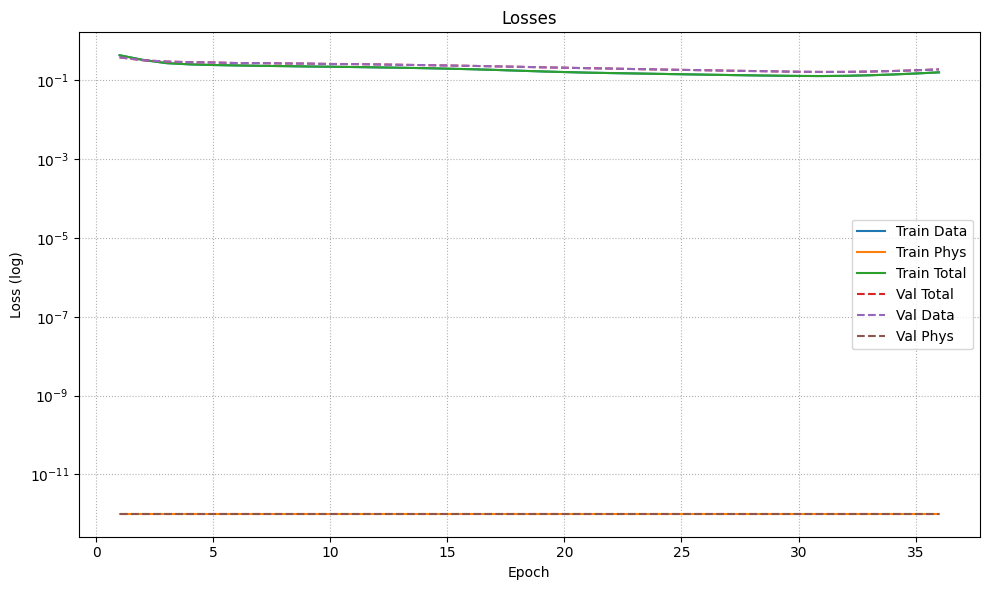

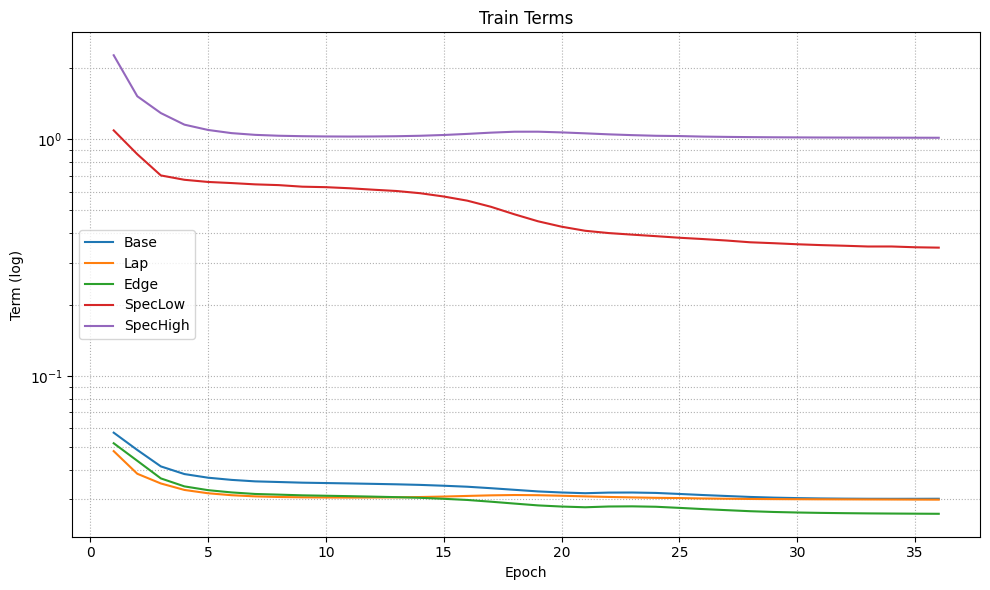

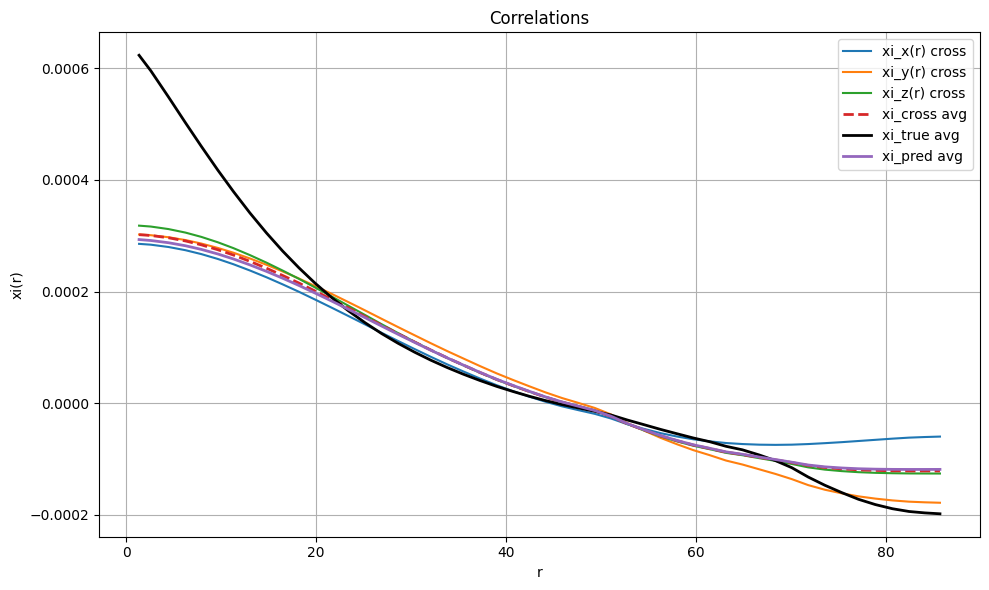

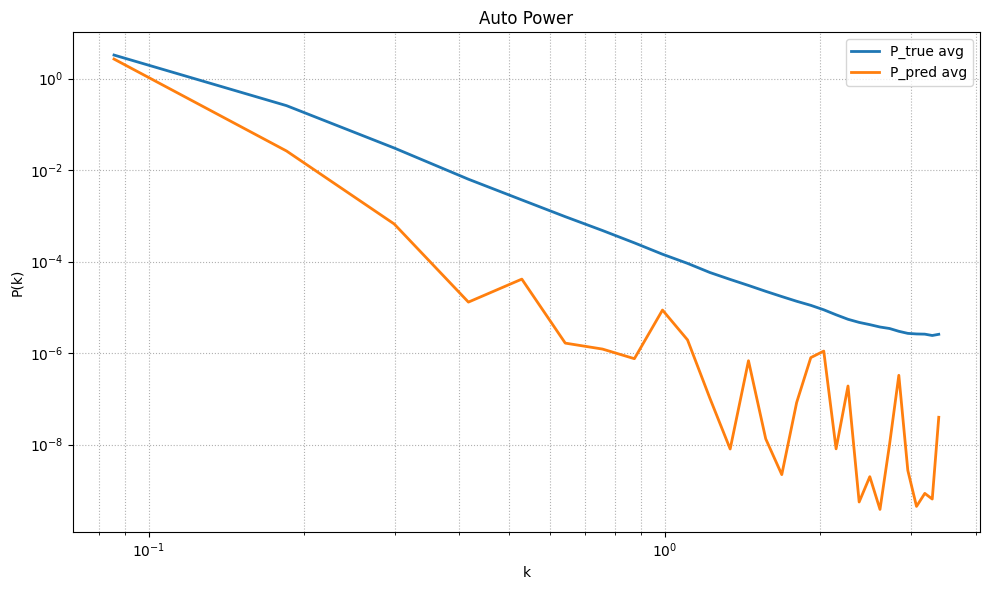

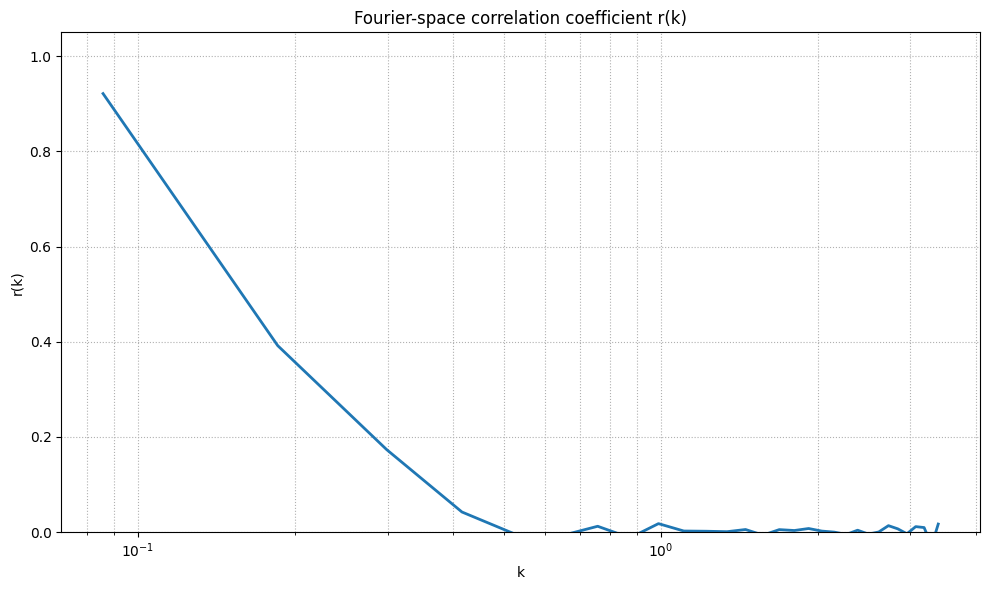

[slice] comp=0 z=32 real[min,max]=(-0.122,0.134) pred[min,max]=(-0.048,0.0485) diff[min,max]=(-0.102,0.111) scale=(-0.134,0.134)


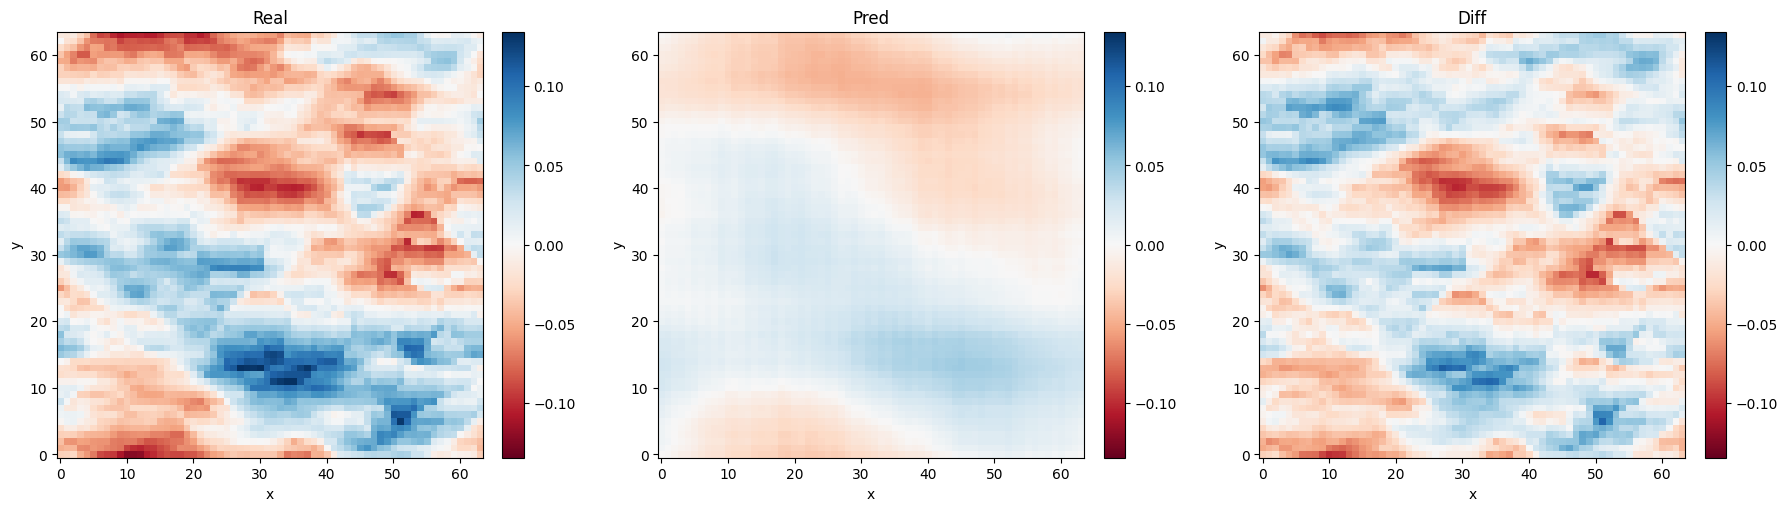

In [45]:
# Block 19: Viz
def cross_correlation_function(field_a, field_b, boxsize=100.0, nbins=50, subtract_mean=True):
    assert field_a.shape == field_b.shape
    N = field_a.shape[0]
    a = field_a.astype(np.float32, copy=False); b = field_b.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64); b = b - np.mean(b, dtype=np.float64)
    Fa = np.fft.fftn(a); Fb = np.fft.fftn(b); V = boxsize ** 3
    Pab = Fa * np.conj(Fb) / V
    xi = np.fft.ifftn(Pab).real
    coords = np.fft.fftfreq(N) * N
    z, y, x = np.meshgrid(coords, coords, coords, indexing="ij")
    r_grid = np.sqrt(x**2 + y**2 + z**2) * (boxsize / N)
    r_flat = r_grid.reshape(-1); xi_flat = xi.reshape(-1)
    rmax = np.max(r_flat); bins = np.linspace(0.0, rmax, nbins + 1)
    which = np.digitize(r_flat, bins) - 1; nbins_eff = len(bins) - 1
    xi_sum = np.zeros(nbins_eff, dtype=np.float64)
    r_sum  = np.zeros(nbins_eff, dtype=np.float64)
    cnt    = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(r_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            xi_sum[bi] += xi_flat[i]; r_sum[bi] += r_flat[i]; cnt[bi] += 1
    mask  = cnt > 0
    r_bin = r_sum[mask] / cnt[mask]; xi_r = xi_sum[mask] / cnt[mask]
    return r_bin, xi_r

def _make_k_grid(N, boxsize):
    kf = 2.0 * np.pi / boxsize
    freqs = np.fft.fftfreq(N) * N
    kz, ky, kx = np.meshgrid(freqs, freqs, freqs, indexing="ij")
    kx = kx * kf; ky = ky * kf; kz = kz * kf
    kk = np.sqrt(kx**2 + ky**2 + kz**2)
    return kx, ky, kz, kk

def power_spectrum_auto(field, boxsize=100.0, nbins=30, subtract_mean=True):
    N = field.shape[0]
    a = field.astype(np.float32, copy=False)
    if subtract_mean: a = a - np.mean(a, dtype=np.float64)
    Fa = np.fft.fftn(a); V = boxsize ** 3
    P = (Fa * np.conj(Fa)).real / V
    _, _, _, kk = _make_k_grid(N, boxsize)
    k_flat = kk.reshape(-1); P_flat = P.reshape(-1)
    kmax = k_flat.max(); bins = np.linspace(0.0, kmax, nbins + 1)
    which = np.digitize(k_flat, bins) - 1; nbins_eff = len(bins) - 1
    P_sum = np.zeros(nbins_eff, dtype=np.float64)
    k_sum = np.zeros(nbins_eff, dtype=np.float64)
    cnt   = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(k_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            P_sum[bi] += P_flat[i]; k_sum[bi] += k_flat[i]; cnt[bi] += 1
    mask = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]; Pk = P_sum[mask] / cnt[mask]
    return k_bin, Pk

def power_spectrum_cross(field_a, field_b, boxsize=100.0, nbins=30, subtract_mean=True):
    assert field_a.shape == field_b.shape
    N = field_a.shape[0]
    a = field_a.astype(np.float32, copy=False); b = field_b.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64); b = b - np.mean(b, dtype=np.float64)
    Fa = np.fft.fftn(a); Fb = np.fft.fftn(b); V = boxsize ** 3
    Pab = (Fa * np.conj(Fb)) / V
    _, _, _, kk = _make_k_grid(N, boxsize)
    k_flat = kk.reshape(-1); P_flat = Pab.real.reshape(-1)
    kmax = k_flat.max(); bins = np.linspace(0.0, kmax, nbins + 1)
    which = np.digitize(k_flat, bins) - 1; nbins_eff = len(bins) - 1
    P_sum = np.zeros(nbins_eff, dtype=np.float64)
    k_sum = np.zeros(nbins_eff, dtype=np.float64)
    cnt   = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(k_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            P_sum[bi] += P_flat[i]; k_sum[bi] += k_flat[i]; cnt[bi] += 1
    mask = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]; Pk = P_sum[mask] / cnt[mask]
    return k_bin, Pk

if 'data_losses' not in globals() or not isinstance(data_losses, list) or len(data_losses) == 0:
    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location='cpu')
        data_losses       = ckpt.get('data_losses', [])
        phys_losses       = ckpt.get('phys_losses', [])
        total_losses      = ckpt.get('total_losses', [])
        base_disp_hist    = ckpt.get('base_disp_hist', [])
        lap_losses_hist   = ckpt.get('lap_losses_hist', [])
        edge_losses_hist  = ckpt.get('edge_losses_hist', [])
        spec_low_hist     = ckpt.get('spec_low_hist', [])
        spec_high_hist    = ckpt.get('spec_high_hist', [])
        val_data_losses   = ckpt.get('val_data_losses', [])
        val_phys_losses   = ckpt.get('val_phys_losses', [])
        val_total_losses  = ckpt.get('val_total_losses', [])
    else:
        data_losses = phys_losses = total_losses = []
        base_disp_hist = lap_losses_hist = edge_losses_hist = []
        spec_low_hist = spec_high_hist = []
        val_data_losses = val_phys_losses = val_total_losses = []

_EPS = 1e-12
def _safe_pos(seq):
    arr = np.array(seq, dtype=np.float64) if len(seq) else np.array([], dtype=np.float64)
    if arr.size: arr = np.maximum(arr, _EPS)
    return arr

epochs_list = list(range(1, len(data_losses) + 1))
plt.figure(figsize=(10, 6))
if len(data_losses): plt.semilogy(epochs_list, _safe_pos(data_losses), label='Train Data')
if len(phys_losses): plt.semilogy(epochs_list, _safe_pos(phys_losses), label='Train Phys')
if len(total_losses): plt.semilogy(epochs_list, _safe_pos(total_losses), label='Train Total')
if len(val_total_losses):
    ev = list(range(1, len(val_total_losses) + 1))
    plt.semilogy(ev, _safe_pos(val_total_losses), label='Val Total', linestyle='--')
if len(val_data_losses):
    evd = list(range(1, len(val_data_losses) + 1))
    plt.semilogy(evd, _safe_pos(val_data_losses), label='Val Data', linestyle='--')
if len(val_phys_losses):
    evp = list(range(1, len(val_phys_losses) + 1))
    plt.semilogy(evp, _safe_pos(val_phys_losses), label='Val Phys', linestyle='--')
plt.xlabel('Epoch'); plt.ylabel('Loss (log)'); plt.title('Losses'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

have_terms = any(len(x) for x in [base_disp_hist, lap_losses_hist, edge_losses_hist, spec_low_hist, spec_high_hist])
if have_terms:
    plt.figure(figsize=(10, 6))
    if len(base_disp_hist):  plt.semilogy(range(1, len(base_disp_hist)+1),  _safe_pos(base_disp_hist),  label='Base')
    if len(lap_losses_hist): plt.semilogy(range(1, len(lap_losses_hist)+1), _safe_pos(lap_losses_hist), label='Lap')
    if len(edge_losses_hist):plt.semilogy(range(1, len(edge_losses_hist)+1),_safe_pos(edge_losses_hist),label='Edge')
    if len(spec_low_hist):   plt.semilogy(range(1, len(spec_low_hist)+1),   _safe_pos(spec_low_hist),   label='SpecLow')
    if len(spec_high_hist):  plt.semilogy(range(1, len(spec_high_hist)+1),  _safe_pos(spec_high_hist),  label='SpecHigh')
    plt.xlabel('Epoch'); plt.ylabel('Term (log)'); plt.title('Train Terms'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

if 'model' not in globals():
    try:
        model = UNet3D(pos_embed=pos_embed, use_cond=ROI_CONDITIONING).to(device)
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Loaded best model: {best_model_path}")
        elif os.path.exists(checkpoint_path):
            ckpt = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(ckpt['model_state_dict'])
            print(f"Loaded model from checkpoint: {checkpoint_path}")
        else:
            print("No model weights found.")
    except Exception as e:
        print(f"[warn] Model build failed: {e}")

if 'dataset' not in globals():
    dataset = LSSDataset(precomputed_dir, num_sim, preload=False, cache_size=64, np_dtype=np.float16,
                         scale_disp=DISP_SCALE)

model.eval()
with torch.no_grad():
    try:
        rho_test, tilde_real = dataset[0]
    except Exception:
        ridx = np.random.randint(0, len(dataset))
        rho_test, tilde_real = dataset[ridx]
    rho_test = rho_test.unsqueeze(0).to(device, dtype=torch.float32)
    pred = model(rho_test)[0].cpu()
    tilde_real = tilde_real.cpu()

pred_np = pred.numpy().astype(np.float32)
real_np = tilde_real.numpy().astype(np.float32)

xi_cross_components = []; r_vals = None
for c in range(3):
    r, xi = cross_correlation_function(real_np[c], pred_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_cross_components.append(xi)
    if r_vals is None: r_vals = r
xi_cross_avg = np.mean(np.stack(xi_cross_components, axis=0), axis=0)

xi_true_components = []
for c in range(3):
    _, xi_t = cross_correlation_function(real_np[c], real_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_true_components.append(xi_t)
xi_true_avg = np.mean(np.stack(xi_true_components, axis=0), axis=0)

xi_pred_components = []
for c in range(3):
    _, xi_p = cross_correlation_function(pred_np[c], pred_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_pred_components.append(xi_p)
xi_pred_avg = np.mean(np.stack(xi_pred_components, axis=0), axis=0)

plt.figure(figsize=(10, 6))
for c, name in enumerate(['x', 'y', 'z']):
    plt.plot(r_vals, xi_cross_components[c], label=fr'xi_{name}(r) cross')
plt.plot(r_vals, xi_cross_avg, linestyle='--', linewidth=2.0, label='xi_cross avg')
plt.plot(r_vals, xi_true_avg, color='k', linewidth=2.0, label='xi_true avg')
plt.plot(r_vals, xi_pred_avg, linewidth=2.0, label='xi_pred avg')
plt.xlabel('r'); plt.ylabel('xi(r)'); plt.title('Correlations'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

NBINS_K = 30
Pk_true_components = []; Pk_pred_components = []; Pk_cross_components = []; k_vals = None
for c in range(3):
    k_t, Pt = power_spectrum_auto(real_np[c], boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    k_p, Pp = power_spectrum_auto(pred_np[c],  boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    k_c, Pc = power_spectrum_cross(real_np[c], pred_np[c], boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    Pk_true_components.append(Pt); Pk_pred_components.append(Pp); Pk_cross_components.append(Pc)
    if k_vals is None: k_vals = k_t
Pk_true_avg  = np.mean(np.stack(Pk_true_components, axis=0), axis=0)
Pk_pred_avg  = np.mean(np.stack(Pk_pred_components, axis=0), axis=0)
Pk_cross_avg = np.mean(np.stack(Pk_cross_components, axis=0), axis=0)
eps = 1e-20
rk = Pk_cross_avg / np.sqrt((Pk_true_avg + eps) * (Pk_pred_avg + eps))

plt.figure(figsize=(10, 6))
plt.loglog(k_vals, Pk_true_avg, label='P_true avg', linewidth=2.0)
plt.loglog(k_vals, Pk_pred_avg, label='P_pred avg', linewidth=2.0)
plt.xlabel('k'); plt.ylabel('P(k)'); plt.title('Auto Power'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 6))
plt.semilogx(k_vals, rk, linewidth=2.0)
plt.ylim(0.0, 1.05)
plt.xlabel('k'); plt.ylabel('r(k)'); plt.title('Fourier-space correlation coefficient r(k)')
plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

component = 0
slice_idx = grid // 2
real_slice = real_np[component, :, :, slice_idx]
pred_slice = pred_np[component, :, :, slice_idx]
diff_slice = real_slice - pred_slice
v = float(np.max(np.abs([real_slice, pred_slice, diff_slice]))); v = max(v, 1e-6)
vmin, vmax = -v, v
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
im1 = axs[0].imshow(real_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[0].set_title('Real'); plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
im2 = axs[1].imshow(pred_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[1].set_title('Pred'); plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
im3 = axs[2].imshow(diff_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[2].set_title('Diff'); plt.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.set_xlabel('x'); ax.set_ylabel('y')
print(f"[slice] comp={component} z={slice_idx} real[min,max]=({real_slice.min():.3g},{real_slice.max():.3g}) "
      f"pred[min,max]=({pred_slice.min():.3g},{pred_slice.max():.3g}) "
      f"diff[min,max]=({diff_slice.min():.3g},{diff_slice.max():.3g}) "
      f"scale=({vmin:.3g},{vmax:.3g})")
plt.show()